In [1]:
# load libraries
import os
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
from torchvision import transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# mount to drive
from google.colab import drive
drive.mount('/content/drive')

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


In [2]:
class CocoCountDataset(Dataset):
    def __init__(self, img_dir, inst_ann_file, caps_ann_file, words, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.coco_annotations = COCO(inst_ann_file) # annotations per instance
        self.coco_caps = COCO(caps_ann_file) # captions per image
        self.words=words # words for filtering
        self.transform = transform
        self.downloaded_imgs = set(os.listdir(self.img_dir)) # get the set of downloaded images
        self.img_ids = self._filter_images() # apply filter method and get ids for relevant images
        if max_samples:
            self.img_ids = self.img_ids[:max_samples]
        if not self.img_ids:
            raise ValueError("No valid images found after filtering non-existing files.")

    def _filter_images(self):
        cat_ids = self.coco_annotations.getCatIds(catNms=['person']) # from annotations file get category ids for person category
        img_ids = self.coco_annotations.getImgIds(catIds=cat_ids) # get image ids for that match these category ids
        filtered_img_ids = []
        for img_id in img_ids:
            img_info = self.coco_annotations.loadImgs(img_id)[0] # get info for the image
            img_filename = img_info['file_name'] # get the filename from the info
            if img_filename in self.downloaded_imgs:
                ann_ids = self.coco_annotations.getAnnIds(imgIds=img_id, iscrowd=None) # get annotation ids for the image
                anns = self.coco_annotations.loadAnns(ann_ids) # get the actual annotations
                if any(ann['bbox'] for ann in anns): # if there is any bounding box in the annotations
                    cap_ids = self.coco_caps.getAnnIds(imgIds=img_id)
                    caps = self.coco_caps.loadAnns(cap_ids) # get the caption associated with the image
                    for cap in caps:
                        caption = cap['caption'].lower()
                        if any(word in caption for word in self.words):
                            filtered_img_ids.append(img_id) # append the image id if any word in the caption matches with the predefined words
                            break

        print(f"Found {len(filtered_img_ids)} images matching criteria.")
        return filtered_img_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco_annotations.loadImgs(img_id)[0] # load the info of the specified image
        img_path = os.path.join(self.img_dir, img_info['file_name']) # get the file name of this image

        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco_annotations.getAnnIds(imgIds=img_id, catIds=self.coco_annotations.getCatIds(catNms=['person']), iscrowd=None)
        anns = self.coco_annotations.loadAnns(ann_ids)
        count = len(anns)  # Number of people in the image

        if self.transform: # apply transformations if specified
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)

In [33]:
# paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"
coco_train_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/captions_train2017.json"
coco_val_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/instances_val2017.json"
coco_val_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/captions_val2017.json"

# paths to the image directory
train_img_dir = "/content/drive/MyDrive/COCO_dataset/train/train/data"
val_img_dir = "/content/drive/MyDrive/COCO_dataset/validation/validation/data"

# words to filter in captions
words = ['street', 'road', 'city']

# set the max number of samples
max_samples = 50

# create transformation object
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(), # randomly flip horizontally
    transforms.RandomRotation(10), # randomly rotate by 10 degrees
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # random affine transformations
    transforms.ToTensor(), # transform to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalize to range (-1, 1) for all three channels
])

train_dataset = CocoCountDataset(
    img_dir=train_img_dir,
    inst_ann_file=coco_train_inst_ann_file,
    caps_ann_file=coco_train_caps_ann_file,
    transform=transform,
    words=words,
    max_samples=max_samples
    )
print(f"Number of training images: {len(train_dataset)}")

val_dataset = CocoCountDataset(
    img_dir=val_img_dir,
    inst_ann_file=coco_val_inst_ann_file,
    caps_ann_file=coco_val_caps_ann_file,
    transform=transform,
    words=words,
    max_samples=max_samples
    )
print(f"Number of validation images: {len(val_dataset)}")

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

loading annotations into memory...
Done (t=17.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
Found 2281 images matching criteria.
Number of training images: 50
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Found 468 images matching criteria.
Number of validation images: 50


In [29]:
# define the CNN class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x, round_output=False):
        x = self.features(x)
        last_conv_output = x
        x = self.classifier(x)

        if round_output:
            x = torch.round(x)
        return x, last_conv_output


cnn_model = CNN().to(device)

summary(cnn_model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
           Dropout-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [30]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [31]:
def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]

            optimizer.zero_grad()
            output, _ = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]
                output, _ = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

Epoch: 1, Training Loss: 40.9902, Validation Loss: 55.9780
Validation loss decreased (55.978017 --> 55.978017).  Saving model ...
Epoch: 2, Training Loss: 56.1867, Validation Loss: 40.6872
Validation loss decreased (55.978017 --> 40.687243).  Saving model ...
Epoch: 3, Training Loss: 30.6085, Validation Loss: 34.7013
Validation loss decreased (40.687243 --> 34.701344).  Saving model ...
Epoch: 4, Training Loss: 31.0446, Validation Loss: 34.5363
Validation loss decreased (34.701344 --> 34.536283).  Saving model ...
Epoch: 5, Training Loss: 27.1321, Validation Loss: 31.6016
Validation loss decreased (34.536283 --> 31.601578).  Saving model ...
Epoch: 6, Training Loss: 30.6670, Validation Loss: 32.0322
Epoch: 7, Training Loss: 43.0206, Validation Loss: 31.7105
Epoch: 8, Training Loss: 23.5594, Validation Loss: 29.3106
Validation loss decreased (31.601578 --> 29.310575).  Saving model ...
Epoch: 9, Training Loss: 17.9017, Validation Loss: 27.7926
Validation loss decreased (29.310575 --> 27

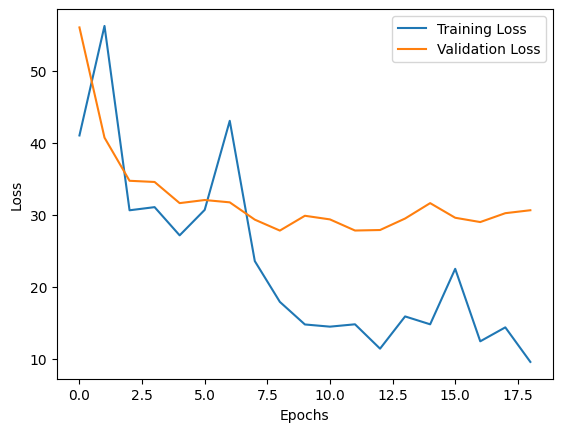

In [34]:
# set hyperparameters
epochs = 50
patience = 10
lr = 0.001
reg = 0.0001

criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=reg)
early_stopper = EarlyStopping(patience=patience)

# training the model
train_losses, val_losses = train_cnn_model(epochs, cnn_model, cnn_optimizer, criterion, train_loader, val_loader, early_stopper)

# plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, count in data_loader:
            images, count = images.to(device), count.to(device)
            outputs, _ = model(images, round_output=True)
            y_preds.extend(outputs.cpu().numpy())
            y_true.extend(count.cpu().numpy())

    mae = mean_absolute_error(y_true, y_preds)
    mse = mean_squared_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    return mae, mse, r2

In [35]:
# evaluate on the validation set
evaluate_model(val_loader, cnn_model)

Mean Absolute Error (MAE): 3.0600
Mean Squared Error (MSE): 16.3800
R-squared (R2): 0.0047


(3.06, 16.38, 0.004715112731931814)

In [ ]:
# evaluate on the test set

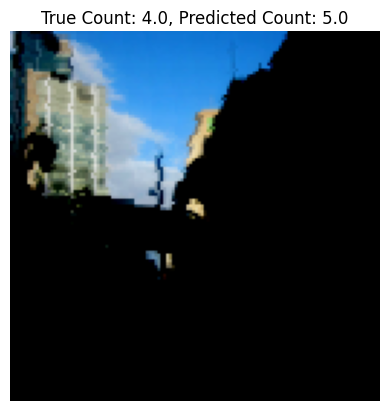

In [36]:
def visualize_prediction(model, dataset, index=0):
    model.eval()  # Set the model to evaluation mode

    # Get the image and ground truth count from the dataset
    image, true_count = dataset[index]

    # Add a batch dimension and pass the image through the model to get the prediction
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        predicted_count, _ = model(image_tensor)  # Unpack the output tuple
        predicted_count = torch.round(predicted_count).item()  # Round and convert to scalar

    # Convert the image tensor to a numpy array and transpose it to (H, W, C) format
    image_np = image.cpu().numpy().transpose(1, 2, 0)

    # Plot the image
    plt.imshow(image_np)
    plt.title(f"True Count: {true_count}, Predicted Count: {predicted_count}")
    plt.axis('off')
    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(cnn_model, val_dataset, index = 4)